In [1]:
import math
import pickle
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
%matplotlib inline

__author__ = 'Kiks'

def triM(*args):
    startM=args[0]
    for m in args[1:]:
        startM=startM.dot(m)
    return startM

def getX_min(x_row,o_row,timeD):
    xn1=x_row[0]+o_row[1]*math.cos(x_row[2])*timeD
    yn1=x_row[1]+o_row[1]*math.sin(x_row[2])*timeD
    thet1=x_row[2]+o_row[2]*timeD
    return np.array([xn1,yn1,thet1])
def getHfun(curX,lanX):
    v=math.sqrt((curX[0]-lanX[0])**2+(curX[1]-lanX[1])**2)
    w=math.atan2(lanX[1]-curX[1],lanX[0]-curX[0])- turnAng(curX[2])
    return np.array([v,turnAng(w)])

def getH(curX,lanX,Hfun):
    VpoX=(curX[0]-lanX[0])/(Hfun[0])
    VpoY=(curX[1]-lanX[1])/(Hfun[0])
    denWder=( (lanX[0]-curX[0])**2 +(lanX[1]-curX[1])**2 )
    
    WpoX=(lanX[1]-curX[1])/denWder
    WpoY=-(lanX[0]-curX[0])/denWder
    
    WpoTh=-1
    return np.array([ [VpoX,VpoY,0],[WpoX,WpoY,-1] ])
    
def getA(x_row,o_row,timeD):
    a=np.eye(3,3)
    a[0,2]=-o_row[1]*math.sin(x_row[2])*timeD
    a[1,2]=o_row[1]*math.cos(x_row[2])*timeD
    return a
def getP_min(AK,PK_1,QK):
    return triM(AK,PK_1,AK.T) + \
    (QK)

def getK(PK_,HK,RK):
    return triM(PK_,HK.T,
           pinv(  triM(HK,PK_,HK.T)
                   +RK))

def getX_post(x_row,KK,z_row,h_row):
    return x_row+triM(KK,(z_row-h_row))

def getP(I,KK,HK,PK_):
    return  (I- np.dot(KK,HK)).dot(PK_)
def absdist(x1,x2):
    return abs(x1[0]-x2[0])+abs(x1[1]-x2[1])

def getbaseX(groun,odom):
    if len(odom)<1:
        print('no ground baseX')
        sys.exit(-5)
    fin=np.where(groun[:,0]<=odom[0,0])[0]
    if len(fin)<1:
        print("no baseX for first odom")
        sys.exit(-5)
        #return getbaseX(groun,odom[1:])
    return fin[-1]
def euc_dist(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 )
def  getGrounForOdom(groun,odom):
    return [np.where(groun[:,0]>=o[0])[0][0] for o in odom]

  

In [2]:
def process(groun,odom,meas,btwn_Ms,lanDik,Qerror=1e-5,Rerror=1e-1,isCorrect=True):
    btwn_Ms=np.array(btwn_Ms,dtype=int)
    
    fInd1=getbaseX(groun,odom)
    print(fInd1)
    #sys.exit(-6)
    
    xCalc=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    xCalc[0]=groun[fInd1,1:]
    curTime=groun[fInd1,0]
    
    xTime=np.zeros((odom.shape[0]+1,),dtype=float)
    xTime[0]=curTime
    
    startInd=0
    lenM=len(meas)
    
    PMat=np.zeros((3,3),dtype=float)
    QMat=np.eye(3,dtype=float)*Qerror
    RMat=np.eye(2)*Rerror
    HMat=np.eye(3)
    IMat=np.eye(3,3)

    postEd=np.zeros((odom.shape[0]+1,),dtype=int)
    postEd[0]=1
    
    for i,mind in enumerate(btwn_Ms):
        for insInd in range(startInd,startInd+mind):
            timeD=odom[insInd,0]-curTime
            xCalc[insInd+1]=getX_min(xCalc[insInd],odom[insInd],timeD)
            xTime[insInd+1]=odom[insInd,0]
            
            curA=getA(xCalc[insInd+1],odom[insInd],timeD)
            PMat=getP_min(curA,PMat,QMat)

            curTime=odom[insInd,0]
        startInd+=mind
        
        if isCorrect and mind!=0 and i<lenM and  int(meas[i][1]) in lanDik:
            postEd[startInd]=1
            #print(startInd,xCalc[startInd],PMat)
            
            AlHFun=np.zeros((0,2))
            AlHMat=np.zeros((0,3))
            for kolkuM,mes in enumerate(meas[i:]):
                if mes[0]!=meas[i][0]:
                    kolkuM-=1
                    break
                    
                hFun=getHfun(xCalc[startInd],lanDik[ int(mes[1]) ])
                HMat=getH(xCalc[startInd],lanDik[ int(mes[1])],hFun)
                AlHFun=np.vstack((AlHFun,hFun))
                AlHMat=np.vstack((AlHMat,HMat))
            
            
            print(xCalc[startInd],meas[i:i+kolkuM+1],AlHFun,AlHMat,flush=True)
            sys.exit(-5)
            
            try:
                KMat=getK(PMat,AlHMat,RMat)
            except:
                print(i)
                sys.exit(-10)
            
            
            xCalc[startInd]=getX_post(xCalc[startInd],KMat,
                                      meas[i][2:],AlHFun)           
            #print("\n============\n",getK(PMat,HMat,RMat))
            PMat=getP(IMat,KMat,AlHMat,PMat)
            
            #print('\n\n===================\n',
            #      startInd,xCalc[startInd],KMat,PMat,HMat,hFun,meas[i,:],meas[i][2:]-hFun)
            #sys.exit(-20)
            
    return postEd,xCalc,xTime,fInd1

In [4]:
def plotMov(oldG,newG,oldO,newO,oldOO=None,newOO=None):
    #print(oldG.shape,newG.shape,oldO.shape,newO.shape)
    #sys.exit(-5)
    plt.plot(oldG[:,1],oldG[:,2],color=(0.5647,0.933,0.5647,0.7058),linestyle='--')
    plt.plot(newG[:,1],newG[:,2],'g-')
    plt.scatter(newG[-1,1],newG[-1,2],color='green',s=20)
    
    plt.plot(oldO[:,0],oldO[:,1],color= (1.0, 0.6, 0.6),linestyle='--')
    if oldOO!= None: plt.plot(oldOO[:,0],oldOO[:,1],
                              color= (1.0,165/255,0),linestyle='--')
    # magenta where it actually is posted + final dot
    if len(newO)>0:
        koiC=np.where(newO[:,4]>0.0)[0]
        
        plt.scatter(newO[-1,0],newO[-1,1],color='red',s=50)
        plt.scatter(newO[koiC,0],newO[koiC,1],color='magenta',s=40)      
    if  newOO!= None and len(newOO)>0:    
        plt.scatter(newOO[-1,0],newOO[-1,1],color='orange',s=50)
        
    plt.plot(newO[:,0],newO[:,1],'r-')
    if newOO!= None: plt.plot(newOO[:,0],newOO[:,1],
                              color= (1.0,165/255,0))
def plotLand(lanList):
    plt.scatter(lanList[:,0],lanList[:,1],color='blue',s=50)

In [5]:
def plotAll(groun,xCalc,xTime,postEd,stepRun,maxgrounH,xyAxes,timeStep=1,
            xCalcO=None):
    maxgrounH=60000
    #timeTh=groun[grounH,0]
    oldG=0
    upper=20
    lower=-20
    print("shapes xcalc and xtime and posted",xCalc.shape,xTime.shape,postEd.shape)

    grounS=groun[fInd:]
    lanList=np.array(list(landDik.values()))

    xCalc2=np.clip(xCalc,lower,upper)
    xCalc3=np.vstack((xCalc2.T,xTime,postEd)).T
    if xCalcO!=None:
        np.clip(xCalcO,lower,upper,xCalcO)
        xCalcO=np.vstack((xCalcO.T,xTime,postEd)).T
    oldpXO=np.zeros((0,2))
    pxCalcO=None
    
    print(xCalc3.shape)
    p1xCalc=xCalc3#[np.where(postEd==1)]
    print(p1xCalc[:5,4]==1.0)
    oldpX=np.zeros((0,2))
    oldPlotG=np.zeros((0,3))

    #p2xCalc=p1xCalc[p1xCalc[:,3]<timeTh,:]
    sites=[]

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.85)
    axes=plt.gca()
    axes.set_xlim(xyAxes[0])
    axes.set_ylim(xyAxes[1])
    #plt.subplot(211)
    #plt.plot(np.array(p1xCalc[:,3]<timeTh,dtype=int)[:5])
    for ind,i in enumerate(range(50,maxgrounH,stepRun)):
        if ind%1==0: 
            plt.clf()
            axes=plt.gca()
            axes.set_xlim(xyAxes[0])
            axes.set_ylim(xyAxes[1])
        grounH=i
        print('     \r',grounH,end='',flush=True)
        timeTh=grounS[grounH,0]
        timeThp=grounS[oldG,0]
        p3xCalc=p1xCalc[(p1xCalc[:,3]<=timeTh) & (p1xCalc[:,3]>timeThp),:]
        if xCalcO!=None: pxCalcO=xCalcO[(p1xCalc[:,3]<=timeTh) 
                                        & (p1xCalc[:,3]>timeThp),:]
        
        gBatch=grounS[oldG:grounH,:]

        oldG=i
        print(p3xCalc.shape)
        plotMov(oldPlotG,gBatch,oldpX,p3xCalc,oldpXO,pxCalcO)
        plotLand(lanList)

        sites.append([oldG,grounH,timeThp,timeTh,len(p3xCalc)])
        
        oldpX=p3xCalc
        if xCalcO!=None: oldpXO=pxCalcO
        
        oldPlotG=gBatch

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(timeStep)

    #print (sites)
    sites=np.array(sites)

In [6]:
def getAll(i=3):

    
    oName='datasets/Robot{}_Odometry.dat'.format(i)
    mName='datasets/Robot{}_Measurement.dat'.format(i)
    gName='datasets/Robot{}_Groundtruth.dat'.format(i)
    lName='datasets/Landmark_Groundtruth.dat'
    bName='datasets/Barcodes.dat'

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik
def getAllMulti(dI,Ri=3):

    
    oName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Odometry.dat'.format(dI,Ri)
    mName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Measurement.dat'.format(dI,Ri)
    gName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Groundtruth.dat'.format(dI,Ri)
    lName='datasets/all_data/MRCLAM_Dataset{}/Landmark_Groundtruth.dat'.format(dI,Ri)
    bName='datasets/all_data/MRCLAM_Dataset{}/Barcodes.dat'.format(dI)

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik

In [5]:
np.set_printoptions(precision=12)

i=3
odom,meas,groun,landDik=getAll(i)


print(len(meas),len(set(meas[:,0])))



with open('betw_{}.meas'.format(i),"rb") as f:
    bt_Ms,abt_Ms=pickle.load(f)

with open('betw_{}.groun'.format(i),"rb") as f:
    bt_Gt=pickle.load(f)

print(landDik)

startI=0
startO=sum(abt_Ms[:startI])
print(startI,sum(abt_Ms[startI:]),len(odom[startO:]),len(abt_Ms),len(meas))
plt.figure(figsize=(20,10))

plt.plot(abt_Ms[7135:])
print(min(meas[:,3]),max(meas[:,3]))
postEd,xCalc,xTime,fInd=process(groun,odom[startO:],meas[startI:],
                                abt_Ms[startI:],landDik,Qerror=1e-5,Rerror=1e-1)

NameError: name 'np' is not defined

In [6]:

def oneline(x,rad,point):
    rad=math.tan(rad)
    a=point[1]-rad*point[0]
    return rad*x+a
def twoline(x,pointa,pointb):
    rad=(pointa[1]-pointb[1])/(pointa[0]-pointb[0])
    #print(rad)
    a=pointb[1]-rad*pointb[0]
    return rad*x+a,math.atan(rad)
def stepeni(x):
    return (x*180)/math.pi
def radiani(x):
    return (x*math.pi)/180
def getSign(num):
    return abs(num)/num

def GrounPosNeg(twoG,timeRat):
    if twoG[0,3]*twoG[1,3]<0 and abs(twoG[0,3])>3:    
        dif0=math.pi-abs(twoG[0,3])
        dif1=math.pi-abs(twoG[1,3])
        angRat=dif0/(dif0+dif1)
        if timeRat<=angRat:
            twoG[1,3]=getSign(twoG[0,3])*(math.pi+dif1)
        else:
            twoG[0,3]=getSign(twoG[1,3])*(math.pi+dif0)
    return twoG
def interp(twoG,time):
    twoG[0,3],twoG[1,3]=turnAng(twoG[0,3]),turnAng(twoG[1,3])
    rat=(time-twoG[0,0])/(twoG[1,0]-twoG[0,0])
    twoG=GrounPosNeg(twoG,rat)
    
    return (rat)*twoG[1,1:]+(1-rat)*twoG[0,1:]
def turnAng(x):
    if abs(x)>2*math.pi:
        print('non valid angle !!!!!!!!!!!')
        sys.exit(-10)
    elif abs(x)>math.pi:
        return x-((abs(x)/x)*2*math.pi)
    return x

def getGrounForOdom(groun,odom):
    resL=[]
    for o in odom:
        res=np.where(groun[:,0]>=o[0])[0]
        if len(res)<1:
            print('this o:',o)
            resL.append(-1)
        else:
            resL.append(res[0])
    return resL

def getMeasDif(RobotI):
    odom,meas,groun,landDik=getAll(RobotI)
    lisGO=getGrounForOdom(groun,meas)
    dist=np.zeros((2,))
    kol=0
    stepeniS=np.zeros((meas.shape[0],))
    resDif=np.zeros((meas.shape[0],2))
    kolkuNeprovereni=[]
    for ind,(li,me) in enumerate(zip(lisGO,meas)):
        if int(me[1]) not in landDik: 
            #koiNeLand
            continue
        if li!=-1:
            xt=interp(groun[li-1:li+1],me[0],)
            dist+=(getHfun(xt,landDik[int(me[1])])-me[2:])**2
            kol+=1
            stepeniS[ind]=getHfun(xt,landDik[int(me[1])])[1]
            resDif[ind]=(getHfun(xt,landDik[int(me[1])])-me[2:])#**2
        else:
            kolkuNeprovereni.append(li)

        #print(xt,landDik[int(me[1])],stepeni(getHfun(xt,landDik[int(me[1])])[1]),flush=True)
        # resDif[ind,0]<-1
        # (ind>=1900 and ind<=2000) or
        if  ind%7000==-2668 or ind%7000==-6476:
            myXt=turnAng(xt[2])
            dodX=0.5
            if abs(myXt)>math.pi/2:
                dodX=-0.5
            plt.clf()
            plt.scatter(xt[0],xt[1],color='blue')
            plt.scatter(landDik[int(me[1])][0],landDik[int(me[1])][1],color='orange')
            onel=lambda x: oneline(x,xt[2],xt)
            twol=lambda x: twoline(x,xt,landDik[int(me[1])])

            plt.plot([xt[0],xt[0]+dodX],
                     [onel(xt[0]),onel(xt[0]+dodX)])
            plt.plot([landDik[int(me[1])][0],xt[0]],
                     [twol(landDik[int(me[1])][0] )[0],twol(xt[0])[0]])

            twor=[(str(getHfun(xt,landDik[inLan])[1] ),str(inLan)) for inLan in landDik  ]
            res="agol na plavoto {}, agol razlika: {}, agol meas: {},{} {}\n {}".format(stepeni(xt[2]) , 
                stepeni( getHfun(xt,landDik[int(me[1])]) [1] ),me[3],int(me[1]),resDif[ind],twor)

            lanList=np.array(list(landDik.values()))
            plt.scatter(lanList[:,0],lanList[:,1],color='blue',s=50)

            display.clear_output(wait=True)
            display.display(plt.gcf(),
                            #(onel(xt[0]+dodX)>xt[1])==(xt[2]>0)
                            res,
                         #(stepeni( getHfun(xt,landDik[int(me[1])]) [1] )>0) ==  (onel(landDik[int(me[1])][0])>landDik[int(me[1])][1])
                           )
            time.sleep(1)



    print(ind,dist/kol,sum(resDif),stepeni(min(stepeniS)),stepeni(max(stepeniS)) )

    bigresDif=resDif

    resDif=resDif[resDif[:,0]!=0,:]
    difV,difM=np.var(resDif,0),np.mean(resDif,0)
    #TestresDif=resDif
    
    return resDif,kolkuNeprovereni
 

# RobotI=3
# resDif,kolkuNeprovereni=getMeasDif(RobotI)
# print('Kolku ne prov',len(kolkuNeprovereni))
# print('res dif',np.var(resDif,axis=0))
#VarM=dist/kol
# checking if there are 0 in dif vector because of non landmark measurements

#print(VarM,'Error variance:',np.var(resDif,0),np.mean(resDif,0),len(meas),len(resDif[resDif[:,0]!=0]),kol,
#len([1 for me in meas  if int(me[1]) not in landDik]))


In [8]:
def getMultiMeasDif(dI,RobotI):
    odom,meas,groun,landDik=getAllMulti(dI,RobotI)
    lisGO=getGrounForOdom(groun,meas)
    dist=np.zeros((2,))
    kol=0
    stepeniS=np.zeros((meas.shape[0],))
    resDif=np.zeros((meas.shape[0],2))
    kolkuNeprovereni=[]
    for ind,(li,me) in enumerate(zip(lisGO,meas)):
        if int(me[1]) not in landDik: 
            #koiNeLand
            continue
        if li>0:
            xt=interp(groun[li-1:li+1],me[0],)
            dist+=(getHfun(xt,landDik[int(me[1])])-me[2:])**2
            kol+=1
            stepeniS[ind]=getHfun(xt,landDik[int(me[1])])[1]
            resDif[ind]=(getHfun(xt,landDik[int(me[1])])-me[2:])#**2
        else:
            kolkuNeprovereni.append(li)

        #print(xt,landDik[int(me[1])],stepeni(getHfun(xt,landDik[int(me[1])])[1]),flush=True)
        # resDif[ind,0]<-1
        # (ind>=1900 and ind<=2000) or
        if  ind%7000==-2668 or ind%7000==-6476:
            myXt=turnAng(xt[2])
            dodX=0.5
            if abs(myXt)>math.pi/2:
                dodX=-0.5
            plt.clf()
            plt.scatter(xt[0],xt[1],color='blue')
            plt.scatter(landDik[int(me[1])][0],landDik[int(me[1])][1],color='orange')
            onel=lambda x: oneline(x,xt[2],xt)
            twol=lambda x: twoline(x,xt,landDik[int(me[1])])

            plt.plot([xt[0],xt[0]+dodX],
                     [onel(xt[0]),onel(xt[0]+dodX)])
            plt.plot([landDik[int(me[1])][0],xt[0]],
                     [twol(landDik[int(me[1])][0] )[0],twol(xt[0])[0]])

            twor=[(str(getHfun(xt,landDik[inLan])[1] ),str(inLan)) for inLan in landDik  ]
            res="agol na plavoto {}, agol razlika: {}, agol meas: {},{} {}\n {}".format(stepeni(xt[2]) , 
                stepeni( getHfun(xt,landDik[int(me[1])]) [1] ),me[3],int(me[1]),resDif[ind],twor)

            lanList=np.array(list(landDik.values()))
            plt.scatter(lanList[:,0],lanList[:,1],color='blue',s=50)

            display.clear_output(wait=True)
            display.display(plt.gcf(),
                            #(onel(xt[0]+dodX)>xt[1])==(xt[2]>0)
                            res,
                         #(stepeni( getHfun(xt,landDik[int(me[1])]) [1] )>0) ==  (onel(landDik[int(me[1])][0])>landDik[int(me[1])][1])
                           )
            time.sleep(1)



    print(ind,dist/kol,sum(resDif),stepeni(min(stepeniS)),stepeni(max(stepeniS)) )

    bigresDif=resDif

    resDif=resDif[resDif[:,0]!=0,:]
    difV,difM=np.var(resDif,0),np.mean(resDif,0)
    #TestresDif=resDif
    
    return resDif,kolkuNeprovereni

In [ ]:
"Test spike removal for -3.14 3.14 error"
print(np.where(TestresDif!=resDif))

TestresDif[[2175,5502]],resDif[[2175,5502]]

In [9]:
def plotMeasDif(resDif,doHist=False,doSave=False):
    #np.set_printoptions(precision=12)
    plt.figure(figsize=(20,20))
    plt.subplot(211)
    plt.title("Error from measurement distance and groundtruth data,\n mean: {:.05f},var: {:.05f}".format(difM[0],difV[0]))
    plt.plot(resDif[:,0])

    plt.subplot(212)
    plt.title("Error from measurement angle and groundtruth data,\n mean: {:.05f}, var: {:.05f}".format(difM[1],difV[1]))
    plt.plot(resDif[:,1])
    if doSave:
        plt.savefig("debug section/robots/Error between measurement and groundtruth "+'Robot_{}'.format(RobotI)+".png",dpi=300)
    
    if doHist:
        plt.figure(figsize=(20,20))
        plt.subplot(211)
        plt.title("Histogram of error from measurement distance and groundtruth data, "
                  +"\nmean: {:.05f},var: {:.05f}".format(difM[0],difV[0]))
        plt.hist(resDif[:,0],bins=500)

        plt.subplot(212)
        plt.title("Histogram of error from measurement angle and groundtruth data,"
                  +"\n mean: {:.05f},var: {:.05f}".format(difM[1],difV[1]))
        plt.hist(resDif[:,1],bins=500)
        if doSave:
            plt.savefig("debug section/robots/Histogram of error between measurement and groundtruth "+'Robot_{}'.format(RobotI)+".png",dpi=300)

#print(np.argmax(bigresDif[:,1]),np.where(np.absolute(bigresDif[:,1])>1),meas[np.argmax(resDif[:,1])],
#      stepeniS[np.argmax(resDif[:,1])],min(stepeniS),max(stepeniS))


In [74]:
"Plot Distrib for measur error by angle"
saveErrorAng,doAnglErrPlot,doAnglErrSum=False,True,False

if doAnglErrSum:
    angleError=[np.zeros((0,3)) for i in range(40)]
    distErr=[np.zeros((0,3)) for i in range(40)]
    RobotI=2

    for RobotI in range(40):
        odom,meas,groun,landDik=getAllMulti((RobotI//5)+1,(RobotI%5)+1)
        resDif,kolkuNeprovereni=getMultiMeasDif((RobotI//5)+1,(RobotI%5)+1 )

        measLand=np.array([i for ind,i in enumerate(meas) if int(i[1]) in landDik])
        measLandR=measLand
        if len(kolkuNeprovereni)>=1:
            measLandR=measLand[:-len(kolkuNeprovereni)]
        print('angle shapes',measLandR[:,3].reshape((-1,1)).shape,resDif.shape,len(kolkuNeprovereni))
        angleErrorI=np.hstack((measLandR[:,3].reshape((-1,1)),resDif))


        angleError[RobotI]=np.vstack((angleError[RobotI],angleErrorI))

        distErrI=np.hstack((measLandR[:,2].reshape((-1,1)),resDif))
        distErr[RobotI]=np.vstack((distErr[RobotI],distErrI))

        #print(angleError.shape,distErr.shape,flush=True)


if doAnglErrPlot:
#     plt.figure(figsize=(20,20))
#     plt.subplot(211)
#     plt.title("Distance error by measurement angle")
#     plt.scatter(distErr[:,0],distErr[:,1])
#     plt.subplot(212)
#     plt.title("Angle error by measurement angle")
#     plt.scatter(distErr[:,0],distErr[:,2])
    
    plt.figure(figsize=(10,9))
#     plt.subplot(211)
    plt.title("Distance error based on measurement angle,\n for all robots in the experiment")
    ang
    plt.scatter(angleError[:,0],angleError[:,1])
    plt.xlabel("Angle of Measurement [rad]")
    plt.ylabel("Distance Error [m]")
#     plt.subplot(212)
#     plt.title("Angle error by measurement angle")
#     plt.scatter(angleError[:,0],angleError[:,2])
    
    if saveErrorAng:
        plt.savefig("meas_dist.png",dpi=200)

In [45]:
with open('saved_angle_dist_sepR.bins','wb') as f:
    pickle.dump((angleError,distErr),f)

In [3]:
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)
    
plt.figure(figsize=(10,9))
#     plt.subplot(211)
plt.title("Distance error based on measurement angle,\n for all robots in the experiment")
angleError=np.concatenate([i for i in angleError],axis=0)
distErr=np.concatenate([i for i in distErr ],axis=0)
print('all variances',np.var(angleError[:,1:],axis=0),np.var(distErr[:,1:],axis=0))

indsAng=np.abs(angleError[:,1])<1.2
print('start len',len(angleError))
angleError=angleError[indsAng]
print('end len',len(angleError))

#print('angle err',sum(indsAng),angleError.shape)

varDistance=np.var(angleError[:,1:],axis=0)

# plt.scatter(angleError[:,0],angleError[:,1],c='b',s=0.2)

# plt.hist(angleError[:,1],bins=300)
# plt.figure(figsize=(20,9))
# plt.hist(angleError[:,2],bins=300)
indsDist=np.abs(distErr[:,1])<1.5
distErr=distErr[indsDist]
plt.scatter(distErr[:,0],distErr[:,1],c='b')

plt.xlabel("Angle of Measurement [rad]")
plt.ylabel("Distance Error [m]")
plt.savefig("meas_error_all.png",dpi=220)

all variances [ 0.13441567  0.07991702] [ 0.13441567  0.07991702]
start len 270591
end len 267685


In [98]:
angleError.shape

(6443, 3)

In [102]:
"Bins for Measurement Noise"
def makeBins(anglErs,numBins=200,resInd=1):
    binBorders=np.linspace(min(anglErs[:,0]),
                           max(anglErs[:,0]),numBins+1).reshape(-1,1)
    binRes=np.zeros((numBins,2))
    for ind,bord in enumerate(binBorders[1:]):
        koiAers=anglErs[anglErs[:,0]<=bord]
        binRes[ind]=np.var(koiAers[:,resInd]),len(koiAers)
        
        anglErs=anglErs[anglErs[:,0]>bord]
    return np.hstack((binBorders[1:],binRes))


print('Angle variance is: ',np.var(angleError[:,2]),np.var(distErr[:,2]))
# did 150 acount 
binACount,binDcount=150,30

binARes=makeBins(angleError,binACount,1)
binAResP=binARes
binDRes=makeBins(distErr,binDcount,1)
binDResP=binDRes

dobinDist=False

if not dobinDist:
    print("percentile length inside bin",np.percentile(binARes[:,2],np.linspace(0,100,20)))
    plt.figure(figsize=(20,20))
    plt.subplot(211)
    plt.title("Distance error length ")
    plt.scatter(binAResP[:,0],binAResP[:,2])

    plt.subplot(212)
    plt.title("Distance Error Var")
    plt.scatter(binAResP[:,0],binAResP[:,1])



if dobinDist:
    
    print("percentile length of sumations",np.percentile(binDRes[:,2],np.linspace(0,100,20)))

    plt.figure(figsize=(20,20))
    plt.subplot(211)
    plt.title("Distance error ")
    plt.scatter(binDResP[:,0],binDResP[:,2])

    plt.subplot(212)
    plt.title("Distance Error Var")
    plt.scatter(binDResP[:,0],binDResP[:,1])

Angle variance is:  0.000852197071843 0.000973216426772
percentile length inside bin [   35.            73.36842105   105.           116.05263158   128.21052632
   149.84210526   160.           166.           182.21052632   202.
   212.42105263   220.26315789   226.           233.89473684   244.36842105
   270.15789474   293.47368421   306.57894737   346.47368421  1341.        ]


C:\Users\Kiks\Miniconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [65]:
"Make BinTable"
class binTable:
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,1]
    
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)
angleError=np.concatenate([i for i in angleError])
print(angleError[0].shape)
varDistance=np.var(angleError[:,1:],axis=0)
    
dBin=binTable(alternate=varDistance[0])
aBin=binTable(alternate= varDistance[1])   # 0.00015657)

print('var distance',varDistance)
# print('angle erroor alterantive',np.var(angleError[:,2]),np.var(distErr[:,2]))

# print('distance erroor alterantive',np.var(distErr[:,1]),np.var(angleError[:,1]))
# print(binARes[:5])
# print(dBin.getNoise(87650),dBin.getNoise(-460))

aBinName,dBinName='bins/angle.bins_all3','bins/distance.bins_all3'
toSaveBin=True
if toSaveBin:
    with open(aBinName,'wb') as f:
        pickle.dump(aBin,f)
    with open(dBinName,'wb') as f:
        pickle.dump(dBin,f)
    print('Done !')

(3,)
var distance [ 0.13441567  0.07991702]
Done !


In [41]:
"Making bins for multiple datasets"
class binTable:
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,1]
with open('saved_angle_dist.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)
    
for datas in range(1,9):
    dat_angleErr=np.concatenate([angleError[i] for i in angleError if i !=9 and i==datas],axis=0)

    print('all variances',np.var(dat_angleErr[:,1:],axis=0),len(dat_angleErr))

    #indsAng=np.abs(angleError[:,1])<1.2
    #angleError=angleError[indsAng]
    #print('angle err',sum(indsAng),angleError.shape)

    varDistance=np.var(dat_angleErr[:,1:],axis=0)
    dBin=binTable(alternate=varDistance[0])
    aBin=binTable(alternate= varDistance[1])   # 0.00015657)



    aBinName,dBinName='bins/angle.bins_{}datonev'.format(datas), \
    'bins/distance.bins_{}datonev'.format(datas)
    toSaveBin=True
    if toSaveBin:
        with open(aBinName,'wb') as f:
            pickle.dump(aBin,f)
        with open(dBinName,'wb') as f:
            pickle.dump(dBin,f)
        print('Done !')

all variances [ 1.06049275  0.76975587] 27491
Done !
all variances [ 0.03168854  0.00189489] 37090
Done !
all variances [ 0.02409132  0.00112744] 35156
Done !
all variances [ 0.02240922  0.0010781 ] 32560
Done !
all variances [ 0.02251033  0.00047211] 36414
Done !
all variances [ 0.03374664  0.0054661 ] 15383
Done !
all variances [ 0.04138369  0.00363338] 16067
Done !
all variances [ 0.03149456  0.0019254 ] 70430
Done !


In [58]:
"Making bins for multiple robots "
class binTable:
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,1]
with open('saved_angle_dist_sepR.bins','rb') as f:
    (angleError,distErr)=pickle.load(f)
    
for datas,dat_angleErr in enumerate(angleError):
#     dat_angleErr=np.concatenate([angleError[i] for i in angleError if i !=9 and i==datas],axis=0)

    print('all variances',np.var(dat_angleErr[:,1:],axis=0),len(dat_angleErr))

    #indsAng=np.abs(angleError[:,1])<1.2
    #angleError=angleError[indsAng]
    #print('angle err',sum(indsAng),angleError.shape)

    varDistance=np.var(dat_angleErr[:,1:],axis=0)
    dBin=binTable(alternate=varDistance[0])
    aBin=binTable(alternate= varDistance[1])   # 0.00015657)



    aBinName,dBinName='bins/angle.bins_{}rob'.format(datas), \
    'bins/distance.bins_{}rob'.format(datas)
    toSaveBin=True
    if toSaveBin:
        with open(aBinName,'wb') as f:
            pickle.dump(aBin,f)
        with open(dBinName,'wb') as f:
            pickle.dump(dBin,f)
        print('Done !')

all variances [ 1.28945902  0.83969239] 4771
Done !
all variances [ 1.22570185  1.07681964] 5543
Done !
all variances [ 0.58125193  0.64316422] 6771
Done !
all variances [ 0.77985696  0.88294669] 3269
Done !
all variances [ 1.35078613  0.52368242] 7137
Done !
all variances [ 0.02122089  0.00193909] 6852
Done !
all variances [ 0.03413797  0.00441862] 6049
Done !
all variances [ 0.0342581   0.00242249] 8695
Done !
all variances [ 0.03606031  0.0001878 ] 4011
Done !
all variances [ 0.0319587   0.00068357] 11483
Done !
all variances [ 0.01364704  0.00059822] 7011
Done !
all variances [ 0.02070084  0.00019097] 6697
Done !
all variances [ 0.03112966  0.00223066] 8856
Done !
all variances [ 0.01366332  0.00018544] 2229
Done !
all variances [ 0.0276244   0.00130679] 10363
Done !
all variances [ 0.00964084  0.00104579] 6728
Done !
all variances [ 0.02116841  0.00018665] 5242
Done !
all variances [ 0.01822398  0.00015657] 6443
Done !
all variances [ 0.02937056  0.00101528] 4779
Done !
all varian

In [54]:
varDistance

array([ 0.02240922,  0.0010781 ])

In [ ]:
'Distance Errors'
print(np.where(abs(resDif[:,0])>1),'\n\nRobot is ',RobotI)
print(landDik)
measLand=[(ind,i) for ind,i in enumerate(meas) if int(i[1]) in landDik]
measLand[3973],resDif[3973]

In [ ]:
print("Show the time value of the errors")
np.set_printoptions(precision=12)

RobotI=5
resDif,kolkuNeprovereni=getMeasDif(RobotI)
odom,meas,groun,landDik=getAll(RobotI)
plotMeasDif(resDif)
measLand=np.array([i for i in meas if int(i[1]) in landDik])
whereErr=np.where( abs(resDif[:,1])>0.5 )[0]
print(whereErr,measLand[whereErr,0])

In [ ]:
"Covariance Display"
print(np.cov(resDif.T,ddof=0))
Rerror=[ 0.018226805545,  0.001896513236,0.000182973795]
a=1
invZO=lambda a: a+(1-a)-(1*a)
#invZO=np.vectorize(invZO)
invZO(np.eye(5))
howManyM=4
Rerror[-1]* invZO(np.eye(2*howManyM))+np.eye(2*(howManyM))*np.tile(Rerror[:2],howManyM)

0.572 -0.364
6.624 1.11
128
0.572 -0.331
7.307 1.155
364
0.523 -0.555
9.138 1.05
396
0.523 -0.555
8.074 1.032
198


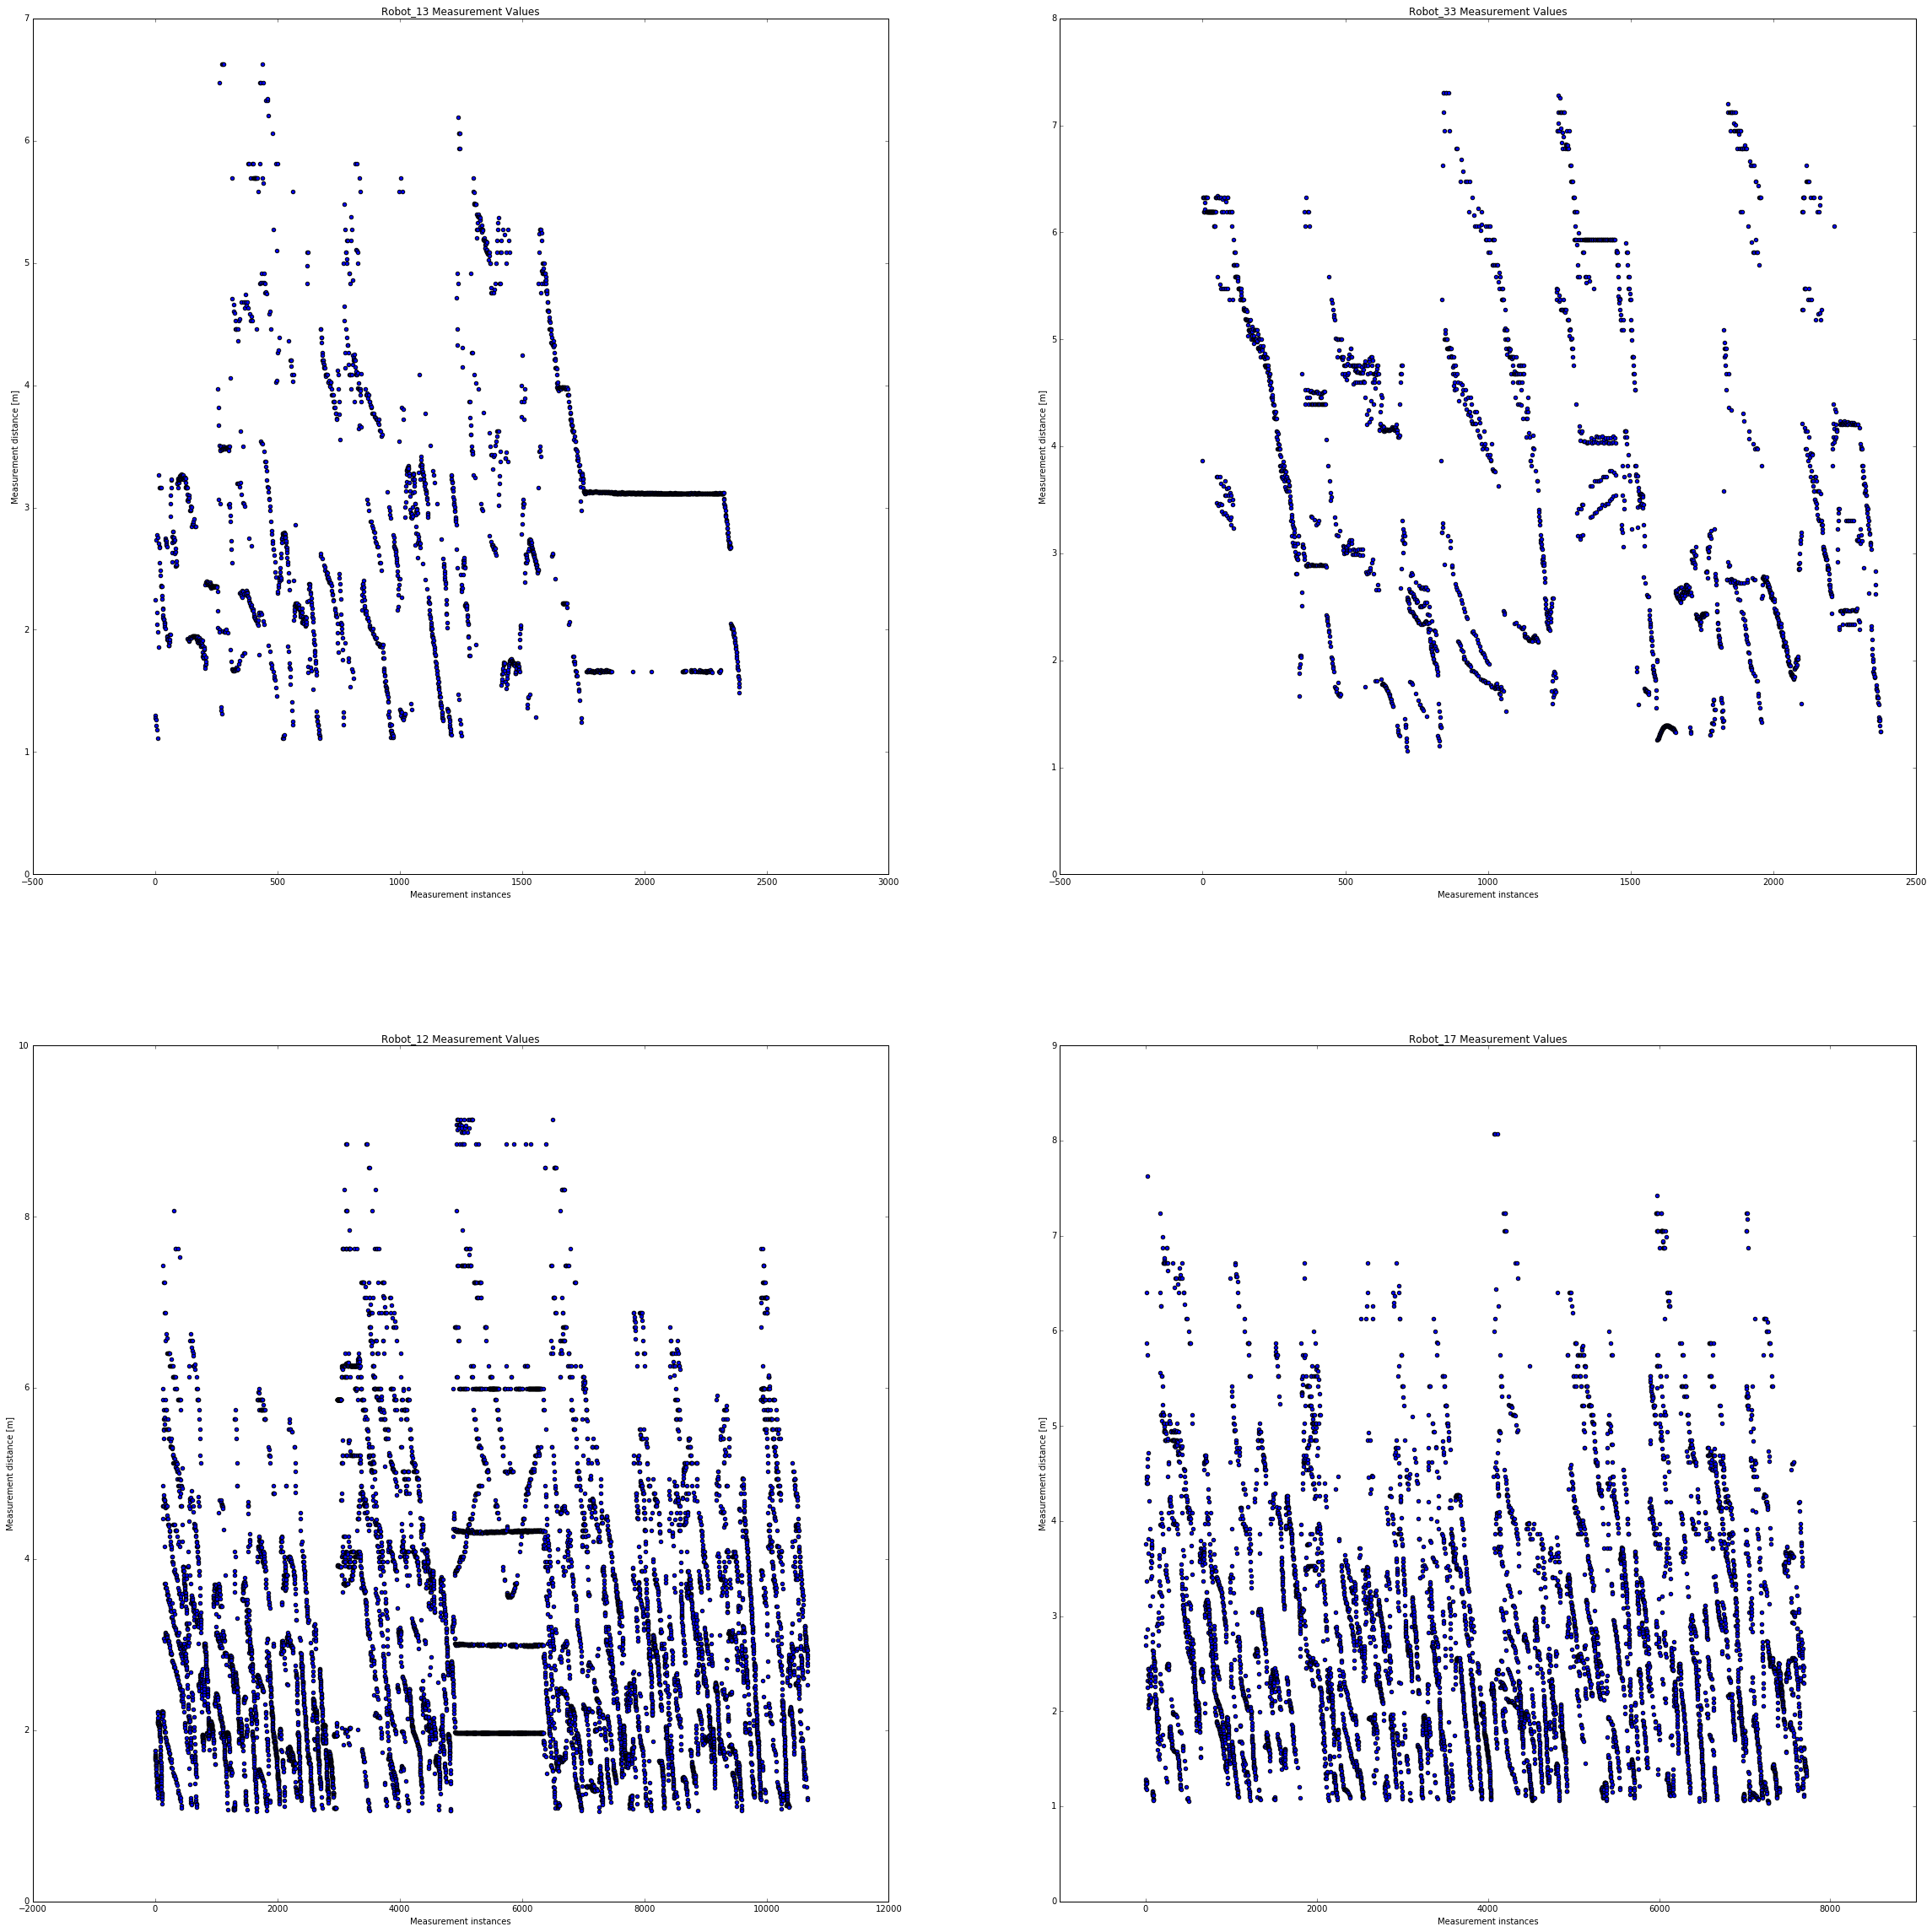

In [26]:
"see Measurement values"
RobotI=1
doPlotAll=True
if doPlotAll:
    f, axarr = plt.subplots(2, 2,figsize=(40,40))
    for robInd,RobotI in enumerate([13,33,12,17]):
        odom,meas,groun,landDik=getAllMulti((RobotI//5)+1,(RobotI%5)+1)
        print(max(meas[:,3]),min(meas[:,3]))
        print(max(meas[:,2]),min(meas[:,2]))
        print(sum(abs(meas[:,3])>0.52))
        #print(np.where(abs(meas[:,3])>0.52))
        
        axarr[robInd//2,robInd%2].set_title("Robot_"+str(RobotI)+" Measurement Values")
        axarr[robInd//2,robInd%2].set_ylabel("Measurement distance [m]")
        axarr[robInd//2,robInd%2].set_xlabel("Measurement instances")
        axarr[robInd//2,robInd%2].scatter(np.arange(len(meas)),meas[:,2])
    #plt.savefig("mrobots_lost.png",dpi=240)

In [1]:
"see Measurement values"
RobotI=1
doPlotAll=True
if doPlotAll:
    
    for datas in range(1,2):
        f, axarr = plt.subplots(2, 2,figsize=(40,40))
        for robInd,RobotI in enumerate([3,33,12,17]):
            datasI,RobotII=(RobotI//5)+1,(RobotI%5)+1
            odom,meas,groun,landDik=getAllMulti(datasI,RobotII)
            print(max(meas[:,3]),min(meas[:,3]))
            print(max(meas[:,2]),min(meas[:,2]))
            print(sum(abs(meas[:,3])>0.52))
            #print('robot: dat{}, robI{} \\length of odom '.format(datas,robInd),len(odom))
            #print(np.where(abs(meas[:,3])>0.52))

            axarr[robInd//2,robInd%2].set_title("Robot_"+str(RobotI)+" Measurement Values")
            axarr[robInd//2,robInd%2].set_ylabel("Measurement distance [m]")
            axarr[robInd//2,robInd%2].set_xlabel("Measurement instances")
            axarr[robInd//2,robInd%2].scatter(np.arange(len(groun)),np.sqrt(np.sum(groun[:,1:3]**2,axis=1)) )
    #plt.savefig("mrobots_stuck.png",dpi=240)

NameError: name 'plt' is not defined

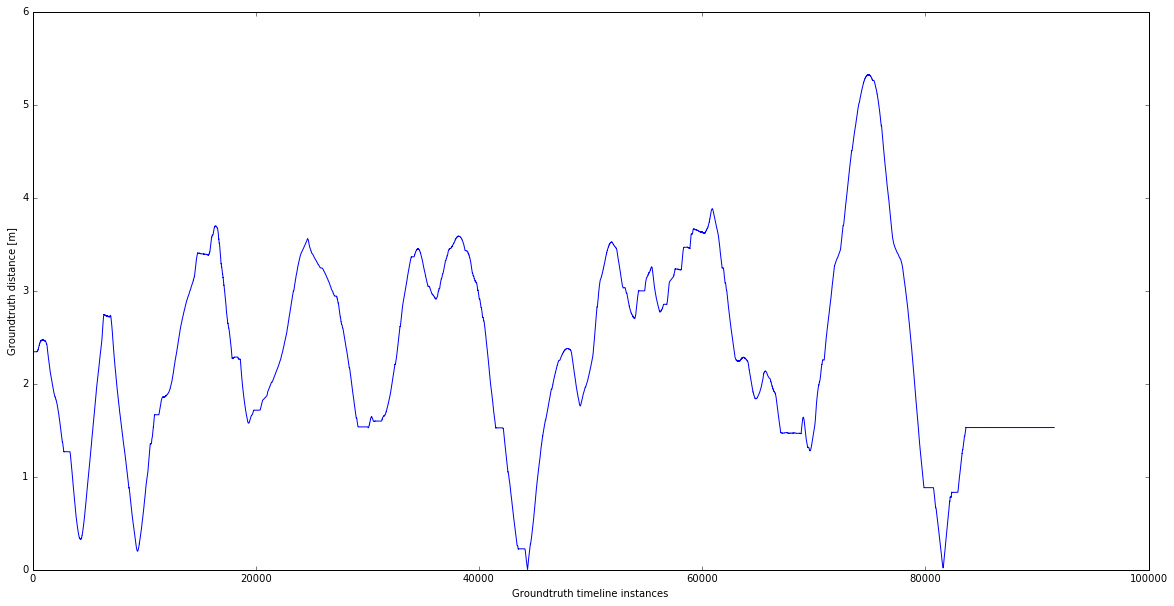

In [7]:
"Plotting for Preprocessing"

plt.figure(figsize=(20,10))

odom,meas,groun,landDik=getAllMulti(1,4)

# plt.subplot(211)
# plt.title("Robot Groundtruth position as a vector")
plt.ylabel("Groundtruth distance [m]")
plt.xlabel("Groundtruth timeline instances")
plt.plot(np.arange(len(groun)),np.sqrt(np.sum(groun[:,1:3]**2,axis=1)) )

odom,meas,groun,landDik=getAllMulti(4,3)

# plt.subplot(212)
# plt.plot(np.arange(len(groun)),np.sqrt(np.sum(groun[:,1:3]**2,axis=1)) )

plt.savefig("bad_robot.png",dpi=120)


In [ ]:
step=-181
stepeni ( ( ((step+(2*math.pi) )%(2*math.pi) )-(2*math.pi) )%(2*math.pi) ),stepeni(step),stepeni(0.21)
(230-180)%360
stepeni(0.64)

In [ ]:
def plotGroun(groun,landDik,stepRun,maxgrounH,xyAxes,timeStep=1,startGroun=50):
    #maxgrounH=60000
    #timeTh=groun[grounH,0]
    oldG=0
    upper=20
    lower=-20

    grounS=groun
    lanList=np.array(list(landDik.values()))
    oldPlotG=np.zeros((0,3))
    #p2xCalc=p1xCalc[p1xCalc[:,3]<timeTh,:]
    sites=[]

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.85)
    axes=plt.gca()
    axes.set_xlim(xyAxes[0])
    axes.set_ylim(xyAxes[1])
    for ind,i in enumerate(range(startGroun,maxgrounH,stepRun)):
        if ind%1==0: 
            plt.clf()
            axes=plt.gca()
            axes.set_xlim(xyAxes[0])
            axes.set_ylim(xyAxes[1])
        grounH=i
        print('     \r',grounH,end='',flush=True)
        timeTh=grounS[grounH,0]
        timeThp=grounS[oldG,0]
        
        gBatch=grounS[oldG:grounH,:]

        oldG=i
        plotGMov(oldPlotG,gBatch)
        plotGLand(lanList)

        sites.append([oldG,grounH,timeThp,timeTh])
        

        
        oldPlotG=gBatch

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(timeStep)

    #print (sites)
    sites=np.array(sites)
def plotGMov(oldG,newG):
    #print(oldG.shape,newG.shape,oldO.shape,newO.shape)
    #sys.exit(-5)
    plt.plot(oldG[:,1],oldG[:,2],color=(0.5647,0.933,0.5647,0.7058),linestyle='--')
    plt.plot(newG[:,1],newG[:,2],'g-')
    plt.scatter(newG[-1,1],newG[-1,2],color='green',s=20)
    
def plotGLand(lanList):
    plt.scatter(lanList[:,0],lanList[:,1],color='blue',s=50)

In [ ]:
"Show the Robot Motion"
RobotI=1
odom,meas,groun,landDik=getAll(RobotI)
#plotGroun(groun,landDik,400,len(groun),[[-1,6],[-6.5,6.5]],0.8,startGroun=60000)
plt.plot(groun[60000:,3])

In [ ]:
def getSign(num):
    return abs(num)/num

def GrounPosNeg(twoG,timeRat):
    if twoG[0,3]*twoG[1,3]<0:    
        dif0=math.pi-abs(twoG[0,3])
        dif1=math.pi-abs(twoG[1,3])
        angRat=dif0/(dif0+dif1)
        if timeRat<=angRat:
            twoG[1,3]=getSign(twoG[0,3])*(math.pi+dif1)
        else:
            twoG[0,3]=getSign(twoG[1,3])*(math.pi+dif0)
    return twoG
def interp(twoG,time):
    print(list(map(turnAng,twoG[:,3])))
    rat=(time-twoG[0,0])/(twoG[1,0]-twoG[0,0])
    twoG=GrounPosNeg(twoG,rat)
    
    return (rat)*twoG[1,1:]+(1-rat)*twoG[0,1:]

tw=np.array([[1,1,1,3.1],[2,1,1,-3.1]])
timeR=1.222
print(interp(tw,timeR)[2]-( 2*(timeR-1)*(math.pi-3.1)+3.1))
